In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.integrate import quad


%matplotlib inline  
%config InlineBackend.figure_format = 'svg'

plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 20
plt.style.use(['seaborn-bright', 'seaborn-paper'])

C:\Users\byron\AppData\Local\Temp\ipykernel_1096\645595640.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-bright', 'seaborn-paper'])
C:\Users\byron\AppData\Local\Temp\ipykernel_1096\645595640.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-bright', 'seaborn-paper'])


In [ ]:

GAMMA_Hz = 42.58 * 1e6 # Hz/T
GAMMA_rad = GAMMA_Hz * 2 * np.pi # rad/s/T

F_m = 0.1 #0.10
F_f = 1.0 - F_m

K_ex = 1.45         # Hz 
# K_ex = 0
k_fm = K_ex / F_f
k_mf = K_ex / F_m  

R1_f = 0.4          # Hz
R1_m = 2.0          # Hz
R2_f = 1 / (50e-3)  # Hz (T2_f = 50ms)
T2_m = 10e-6        # s  (T2_m = 10us), 用于计算 Super-Lorentzian

B1_scale = 1
FA_nominal = 9  # deg
FA_deg = FA_nominal * B1_scale        # deg
N_pulse = 30        
tau = 200e-6        # s, gap
dur = 100e-6        # s, pulse duration
t_spoiler = 1500e-6 # s, spoiler duration
#t_spoiler = 3

# FA = omega1 * dur
omega1_amp = (FA_deg * np.pi / 180.0) / dur 

5.871301080319399


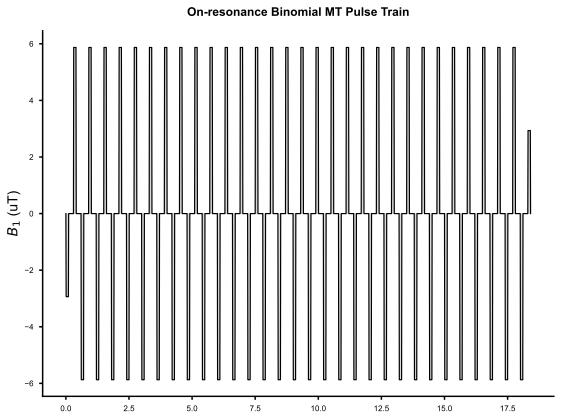

In [ ]:
# Rectangular pulse
dt = 0.01 # ms

Nt_spoiler = int(np.ceil(t_spoiler*1000/dt))
Nt_dur = int(np.ceil(dur*1000/dt))
Nt_delay = int(np.ceil(tau*1000/dt))
B1_amp = FA_deg/(360*GAMMA_Hz*dur)*1e6  # uT
print(B1_amp)

pulse_unit = np.concatenate([np.ones(Nt_dur), np.zeros(Nt_delay), -np.ones(Nt_dur), np.zeros(Nt_delay)])
pulse_train = np.tile(pulse_unit, N_pulse)
pulse_train = B1_amp * np.concatenate([[0],-0.5*np.ones(Nt_dur), np.zeros(Nt_delay), pulse_train, 0.5*np.ones(Nt_dur),[0]]) #, np.zeros(Nt_delay+Nt_spoiler)
time_axis = dt * np.arange(len(pulse_train))

plt.rcParams.update({
    'font.size': 12,
    'font.family': 'sans-serif', # 或 'serif' (Times New Roman)
    'axes.linewidth': 1.5,
    'xtick.major.width': 1.5,
    'ytick.major.width': 1.5
})
# Plot
fig, axes = plt.subplots(1,1,figsize=(8, 6))
axes.plot(time_axis,pulse_train,color='black', linewidth=1.2)
axes.fill_between(time_axis, pulse_train, 0, color='gray', alpha=0.3) # 填充颜色增加可视性
axes.set_ylabel("$B_1$ (uT)", fontsize=14)
axes.set_title("On-resonance Binomial MT Pulse Train", fontsize=12,pad=15, weight='bold')
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)


plt.tight_layout()

#output_fig = "MT_pulse_train.png"
#plt.savefig(output_fig, dpi=300)

plt.show()

In [ ]:
def super_lorentzian(delta_omega, T2):
    def integrand(u):
        denominator = np.abs(3 * u**2 - 1)
        if denominator < 1e-6: denominator = 1e-6 # 避免除零
        term1 = np.sqrt(2/np.pi) * (T2 / denominator)
        term2 = np.exp(-2 * ( (delta_omega * T2) / denominator )**2 )
        return term1 * term2
    if delta_omega == 0:
        return T2_m / np.sqrt(2 * np.pi)
    val, _ = quad(integrand, 0, 1, limit=100)
    return val

g_B_on_res = super_lorentzian(0, T2_m)
g_B_on_res = T2_m / np.sqrt(2 * np.pi)


def get_system_matrix(omega1, delta_w, R_RFB):
    A = np.array([
        [-R2_f, -delta_w,      0,               0],
        [delta_w, -R2_f,      -omega1,          0],
        [0,       omega1,     -(R1_f + k_fm),   k_mf],
        [0,       0,           k_fm,           -(R1_m + k_mf + R_RFB)]
    ])
    C = np.array([0, 0, R1_f * F_f, R1_m * F_m])
    return A, C


def evolve(M, A, C, dt):
    n = A.shape[0]
    A_ext = np.zeros((n+1, n+1))
    A_ext[:n, :n] = A
    A_ext[:n, n] = C
    M_ext = np.append(M, 1)
    M_new_ext = expm(A_ext * dt) @ M_ext
    return M_new_ext[:n]


def run_simulation(df_hz,N_pulse_pairs):
    delta_w = 2 * np.pi * df_hz  # rad/s
    g_B = super_lorentzian(delta_w, T2_m)
    
    M = np.array([0.0, 0.0, F_f, F_m])
    
    mzf_history = []
    mzm_history = []
    time_history = []
    current_time = 0
    
    mzf_history.append(M[2])
    mzm_history.append(M[3])
    time_history.append(current_time)

    # Pulse 0.5 (-)
    R_RFB05 = np.pi * (omega1_amp**2) * g_B/4
    A, C = get_system_matrix(-omega1_amp/2, delta_w, R_RFB05)
    M = evolve(M, A, C, dur)
    current_time += dur
    mzf_history.append(M[2])
    mzm_history.append(M[3])
    time_history.append(current_time)

    # Gap
    A, C = get_system_matrix(0, delta_w, 0)
    M = evolve(M, A, C, tau)
    current_time += tau
    mzf_history.append(M[2])
    mzm_history.append(M[3])
    time_history.append(current_time)

    for i in range(N_pulse_pairs):
        # Pulse 1 (+) 
        R_RFB = np.pi * (omega1_amp**2) * g_B
        A, C = get_system_matrix(omega1_amp, delta_w, R_RFB)
        M = evolve(M, A, C, dur)
        current_time += dur
        mzf_history.append(M[2])
        mzm_history.append(M[3])
        time_history.append(current_time)
        
        # Gap
        A, C = get_system_matrix(0, delta_w, 0)
        M = evolve(M, A, C, tau)
        current_time += tau
        mzf_history.append(M[2])
        mzm_history.append(M[3])
        time_history.append(current_time)
        
        # Pulse 2 (-) 
        A, C = get_system_matrix(-omega1_amp, delta_w, R_RFB)
        M = evolve(M, A, C, dur)
        current_time += dur
        mzf_history.append(M[2])
        mzm_history.append(M[3])
        time_history.append(current_time)
        
        # Gap
        A, C = get_system_matrix(0, delta_w, 0)
        M = evolve(M, A, C, tau)
        current_time += tau
        mzf_history.append(M[2])
        mzm_history.append(M[3])
        time_history.append(current_time)
    
    # Pulse 0.5 (+) 
    R_RFB05 = np.pi * (omega1_amp**2) * g_B/4
    A, C = get_system_matrix(omega1_amp/2, delta_w, R_RFB05)
    M = evolve(M, A, C, dur)
    current_time += dur
    mzf_history.append(M[2])
    mzm_history.append(M[3])
    time_history.append(current_time)

    # Gap 
    #A, C = get_system_matrix(0, delta_w, 0)
    #M = evolve(M, A, C, tau+t_spoiler)
    #current_time += tau+t_spoiler
    #mzf_history.append(M[2])
    #mzm_history.append(M[3])
    #time_history.append(current_time)

    # test
    #A, C = get_system_matrix(0, delta_w, 0)
    #M = evolve(M, A, C, 0.5)
    #current_time += tau+t_spoiler
    #mzf_history.append(M[2])
    #time_history.append(current_time)

    return np.array(time_history), np.array(mzf_history), np.array(mzm_history) 

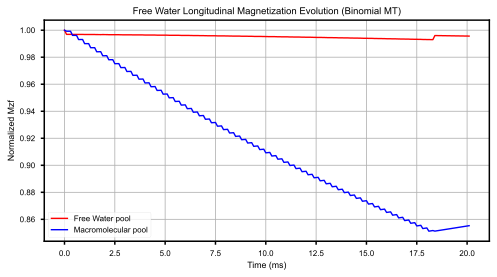

Final Mzf (On-resonance): 0.9956


In [ ]:

t_0, mzf_0, mzm_0 = run_simulation(0,30)

plt.figure(figsize=(8, 4))
plt.plot(t_0 * 1000, mzf_0 / F_f, label='Free Water pool', color='red')
plt.plot(t_0 * 1000, mzm_0 / F_m, label='Macromolecular pool', color='blue')
plt.title('Free Water Longitudinal Magnetization Evolution (Binomial MT)')
plt.xlabel('Time (ms)')
plt.ylabel('Normalized Mzf')
plt.legend()
plt.grid(True)
plt.show()

print(f"Final Mzf (On-resonance): {mzf_0[-1]/F_f:.4f}")
#print(f"Final Mzf (Off-resonance): {mzf_off[-1]/F_f:.4f}")

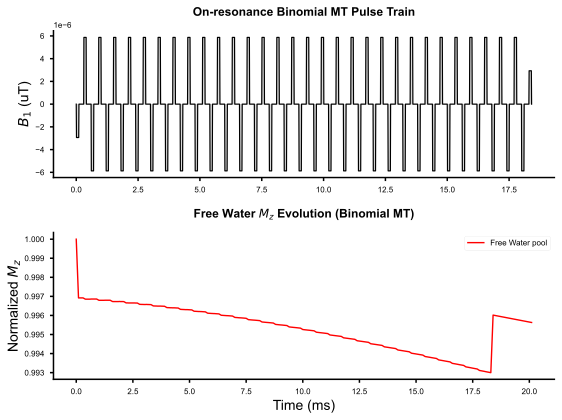

In [ ]:
# Rectangular pulse
dt = 0.01 # ms

Nt_spoiler = int(np.ceil(t_spoiler*1000/dt))
Nt_dur = int(np.ceil(dur*1000/dt))
Nt_delay = int(np.ceil(tau*1000/dt))
B1_amp = FA_deg/(360*GAMMA_Hz*dur)  # uT

pulse_unit = np.concatenate([np.ones(Nt_dur), np.zeros(Nt_delay), -np.ones(Nt_dur), np.zeros(Nt_delay)])
pulse_train = np.tile(pulse_unit, N_pulse)
pulse_train = B1_amp * np.concatenate([[0],-0.5*np.ones(Nt_dur), np.zeros(Nt_delay), pulse_train, 0.5*np.ones(Nt_dur),[0]]) #, np.zeros(Nt_delay+Nt_spoiler)
time_axis = dt * np.arange(len(pulse_train))

plt.rcParams.update({
    'font.size': 12,
    'font.family': 'sans-serif', 
    'axes.linewidth': 1.5,
    'xtick.major.width': 1.5,
    'ytick.major.width': 1.5
})
# Plot
fig, axes = plt.subplots(2,1,figsize=(8, 6))
axes[0].plot(time_axis,pulse_train,color='black', linewidth=1.2)
axes[0].fill_between(time_axis, pulse_train, 0, color='gray', alpha=0.3) 
axes[0].set_ylabel("$B_1$ (uT)", fontsize=14)
axes[0].set_title("On-resonance Binomial MT Pulse Train", fontsize=12,pad=15, weight='bold')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

axes[1].set_ylabel("Normalized $M_z$", fontsize=14)
axes[1].set_title('Free Water $M_z$ Evolution (Binomial MT)', fontsize=12,pad=15, weight='bold')
axes[1].plot(t_0 * 1000, mzf_0 / F_f, label='Free Water pool', color='red')
#axes[1].plot(t_0 * 1000, mzm_0 / F_m, label='Macromolecular pool', color='blue')
axes[1].legend()
axes[1].set_xlabel("Time (ms)", fontsize=14)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)


plt.tight_layout()

#output_fig = "MT_pulse_train.png"
#plt.savefig(output_fig, dpi=300)

plt.show()

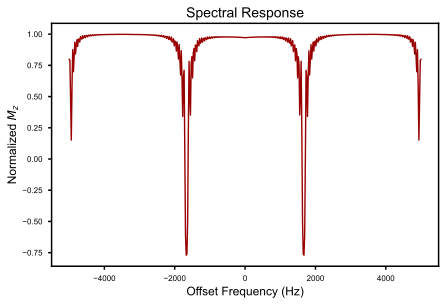

In [ ]:
# Z-spectrum
freq_range = np.linspace(-5000, 5000, 500)
mzf_final = []

for f in freq_range:
    _, mzf_0, _ = run_simulation(f,30)
    mzf_final.append(mzf_0[-1]/F_f)
    
plt.plot(freq_range, mzf_final, '-', color='#990000', markersize=3, label='Free Water Response')
plt.title('Spectral Response', fontsize=14)
plt.xlabel('Offset Frequency (Hz)', fontsize=12)
plt.ylabel('Normalized $M_z$', fontsize=12)
#plt.legend()
#plt.grid(True, linestyle='-', alpha=0.6)

plt.tight_layout()
plt.show()

# 2D EPI

In [ ]:

GAMMA_Hz = 42.58 * 1e6 # Hz/T
GAMMA_rad = GAMMA_Hz * 2 * np.pi # rad/s/T

F_m = 0.1        #0.10
F_f = 1.0 - F_m

K_ex = 1.45         # Hz 
k_fm = K_ex / F_f
k_mf = K_ex / F_m  

R1_f = 0.4          # Hz
R1_m = 2.0          # Hz
R2_f = 1 / (50e-3)  # Hz (T2_f = 50ms)
T2_m = 10e-6        # s  (T2_m = 10us), 用于计算 Super-Lorentzian
T2s = 28e-3      # 28 ms

B1_scale = 1
FA_nominal = 9  # deg
#FA_nominal = 0   # BOLD
FA_deg = FA_nominal * B1_scale        # deg
N_pulse = 30        
tau = 200e-6        # s, gap
dur = 100e-6        # s, pulse duration
t_spoiler = 1500e-6 # s, spoiler duration

omega1_amp = (FA_deg * np.pi / 180.0) / dur 

# EPI
TE = 24e-3       # 24 ms
FA_EPI = 70 * np.pi / 180
TR_volume = 2380e-3 # s
N_slices = 30
N_volumes = 6
target_slice = 10 # 第10层
TR_slice = TR_volume/N_slices

# On-resonance
df_hz = 0 
#g_B = super_lorentzian(2 * np.pi * df_hz, T2_m)
g_B = T2_m / np.sqrt(2 * np.pi)  # Gaussian line shape at 0 Hz
delta_w = 2 * np.pi * df_hz

In [ ]:
def super_lorentzian(delta_omega, T2):
    def integrand(u):
        denominator = np.abs(3 * u**2 - 1)
        if denominator < 1e-6: denominator = 1e-6
        return np.sqrt(2/np.pi)*(T2/denominator)*np.exp(-2*((delta_omega*T2)/denominator)**2)
    if delta_omega == 0:
        return T2 / np.sqrt(2 * np.pi)
    val, _ = quad(integrand, 0, 1, limit=100)
    return val

def get_system_matrix(omega1, delta_w, R_RFB):
    A = np.array([
        [-R2_f, -delta_w,      0,               0],
        [delta_w, -R2_f,      -omega1,          0],
        [0,       omega1,     -(R1_f + k_fm),   k_mf],
        [0,       0,           k_fm,           -(R1_m + k_mf + R_RFB)]
    ])
    C = np.array([0, 0, R1_f * F_f, R1_m * F_m])
    return A, C

def evolve_step(M, A, C, dt):
    n = A.shape[0]
    A_ext = np.zeros((n+1, n+1))
    A_ext[:n, :n] = A
    A_ext[:n, n] = C
    M_ext = np.append(M, 1)
    M_new_ext = expm(A_ext * dt) @ M_ext
    return M_new_ext[:n]


def apply_mt_module(M, g_B, delta_w, omega1_amp):
    # 0.5 (-)
    R_RFB05 = np.pi * (omega1_amp**2) * g_B / 4
    A, C = get_system_matrix(-omega1_amp/2, delta_w, R_RFB05)
    M = evolve_step(M, A, C, dur)
    # Gap
    A, C = get_system_matrix(0, delta_w, 0)
    M = evolve_step(M, A, C, tau)
    # 30 Pairs
    R_RFB = np.pi * (omega1_amp**2) * g_B
    A_pos, C_pos = get_system_matrix(omega1_amp, delta_w, R_RFB)
    A_neg, C_neg = get_system_matrix(-omega1_amp, delta_w, R_RFB)
    A_gap, C_gap = get_system_matrix(0, delta_w, 0)
    
    for _ in range(N_pulse):
        M = evolve_step(M, A_pos, C_pos, dur)
        M = evolve_step(M, A_gap, C_gap, tau)
        M = evolve_step(M, A_neg, C_neg, dur)
        M = evolve_step(M, A_gap, C_gap, tau)
        
    # 0.5 (+)
    A, C = get_system_matrix(omega1_amp/2, delta_w, R_RFB05)
    M = evolve_step(M, A, C, dur)
    # Spoiler Gap
    A, C = get_system_matrix(0, delta_w, 0)
    M = evolve_step(M, A, C, tau + t_spoiler)
    return M


## Evolution by MT module index

In [ ]:

def sim_shot_2DEPI(omega1_amp,target_slice):

    M_slice10 = np.array([0.0, 0.0, F_f, F_m])

    t_mt = (1 + N_pulse)*2*(dur+tau) + t_spoiler 
    t_recovery = TR_slice - t_mt  

    mzf_history = []

    for v in range(N_volumes):
        for s in range(1, N_slices + 1):
            # 无论哪一层采集，全脑都经历MT模块
            M_slice10 = apply_mt_module(M_slice10, g_B, delta_w,omega1_amp)
            mzf_history.append(M_slice10[2]/F_f)    # TR_slice specific
            if s == target_slice:
                #mzf_history.append(M_slice10[2]/F_f)   # TR_volume specific
                mzf_before = M_slice10[2]
                #print(mzf_before/F_f)
                M_slice10[2] = mzf_before * np.cos(FA_EPI)
                M_slice10[0] = 0
                #M_slice10[1] = mzf_before * np.sin(FA_EPI)
                M_slice10[1] = 0
                #sig = mzf_before * np.sin(FA_EPI) * np.exp(-TE/T2s)
                #print(sig/F_f)
                A, C = get_system_matrix(0, delta_w, 0)
                M_slice10 = evolve_step(M_slice10, A, C, t_recovery)
            else:
                A, C = get_system_matrix(0, delta_w, 0)
                M_slice10 = evolve_step(M_slice10, A, C, t_recovery)

    return mzf_history



In [5]:
mtc_history = sim_shot_2DEPI(omega1_amp,1)
bold_history = sim_shot_2DEPI(0,1)

0.6345866008961417
0.8079239187276663
MTR= 0.21454658515928016


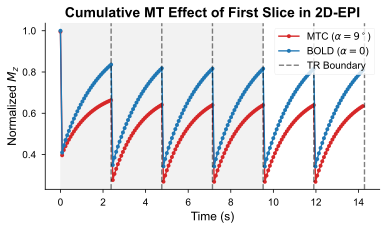

In [ ]:
print(mtc_history[-1])
print(bold_history[-1])
print('MTR=',1-mtc_history[-1]/bold_history[-1])

colors = {"OFF": "#1f77b4", "ON": "#d62728"} 
fig,ax = plt.subplots(1,1,figsize=(6,3))

#plt.figure(figsize=(8, 4))
time_axis = np.arange(0, N_slices*N_volumes)*TR_slice
ax.plot(time_axis, mtc_history, 'o-', markersize=4, color='#d62728',label='MTC ($\\alpha=9^\\circ$)',)
ax.plot(time_axis, bold_history, 'o-', markersize=4, color="#1f77b4",label='BOLD ($\\alpha=0$)',)

#ax.set_xlim(-0.5, N_slices*4*TR_slice + 1)
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Normalized $M_{z}$', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_title(f'Cumulative MT Effect of First Slice in 2D-EPI', fontsize=14, fontweight='bold')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for i in range(1, N_volumes+1):
    boundary = i * N_slices *TR_slice
    if i == 1:
        plt.axvline(boundary, color='k', linestyle='--', alpha=0.5, label='TR Boundary')
    else:
        plt.axvline(boundary, color='k', linestyle='--', alpha=0.5)


plt.axvspan(0, 4 * N_slices*TR_slice, color='gray', alpha=0.1)
ax.legend(loc='upper right', fontsize=10)

plt.show()
fig.savefig('mt_index_2DEPI.png',format='png', bbox_inches='tight',dpi=600)

In [164]:
mtc_5_history = sim_shot_2DEPI(omega1_amp,5)
mtc_15_history = sim_shot_2DEPI(omega1_amp,15)
mtc_25_history = sim_shot_2DEPI(omega1_amp,25)

bold_5_history = sim_shot_2DEPI(0,5)
bold_15_history = sim_shot_2DEPI(0,15)
bold_25_history = sim_shot_2DEPI(0,25)

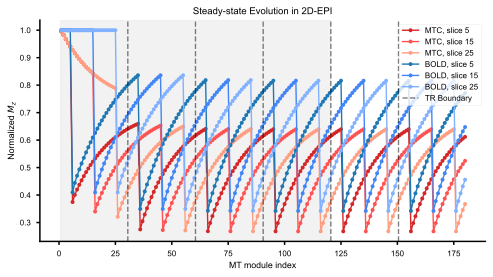

In [ ]:

blue_palette = ['#1f77b4', '#4285f4', '#81b1ff']  
red_palette = ['#d62728', '#ff5252', '#ff9e80']

fig,ax = plt.subplots(1,1,figsize=(8,4))
#plt.figure(figsize=(8, 4))

ax.plot(range(1, N_slices*N_volumes + 1), mtc_5_history, 'o-', markersize=4, color=red_palette[0],label='MTC, slice 5')
ax.plot(range(1, N_slices*N_volumes + 1), mtc_15_history, 'o-', markersize=4, color=red_palette[1],label='MTC, slice 15')
ax.plot(range(1, N_slices*N_volumes + 1), mtc_25_history, 'o-', markersize=4, color=red_palette[2],label='MTC, slice 25')
ax.plot(range(1, N_slices*N_volumes + 1), bold_5_history, 'o-', markersize=4, color=blue_palette[0],label='BOLD, slice 5')
ax.plot(range(1, N_slices*N_volumes + 1), bold_15_history, 'o-', markersize=4, color=blue_palette[1],label='BOLD, slice 15')
ax.plot(range(1, N_slices*N_volumes + 1), bold_25_history, 'o-', markersize=4, color=blue_palette[2],label='BOLD, slice 25')
ax.set_xlabel('MT module index')
ax.set_ylabel('Normalized $M_{z}$')
ax.set_title(f'Steady-state Evolution in 2D-EPI')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for i in range(1, N_volumes):
    boundary = i * N_slices + 0.5
    if i == 1:
        plt.axvline(boundary, color='k', linestyle='--', alpha=0.5, label='TR Boundary')
    else:
        plt.axvline(boundary, color='k', linestyle='--', alpha=0.5)

plt.axvspan(0.5, 4 * N_slices + 0.5, color='gray', alpha=0.1)
plt.legend()
plt.show()

## Evolution by TR

In [ ]:
def sim_TR_2DEPI(omega1_amp,target_slice):

    M_slice10 = np.array([0.0, 0.0, F_f, F_m])
    t_mt = (1 + N_pulse)*2*(dur+tau) + t_spoiler 
    t_recovery = TR_slice - t_mt  

    mzf_history = []
    signal_history = []

    for v in range(N_volumes):
        for s in range(1, N_slices + 1):

            M_slice10 = apply_mt_module(M_slice10, g_B, delta_w,omega1_amp)
            # mzf_history.append(M_slice10[2]/F_f)    # TR_slice specific
            if s == target_slice:
                mzf_history.append(M_slice10[2]/F_f)   # TR_volume specific
                mzf_before = M_slice10[2]
                #print(mzf_before/F_f)
                M_slice10[2] = mzf_before * np.cos(FA_EPI)
                M_slice10[0] = 0
                #M_slice10[1] = mzf_before * np.sin(FA_EPI)
                M_slice10[1] = 0
                sig = mzf_before * np.sin(FA_EPI) * np.exp(-TE/T2s)
                signal_history.append(sig)  # TR_volume specific
                #print(sig/F_f)
                A, C = get_system_matrix(0, delta_w, 0)
                M_slice10 = evolve_step(M_slice10, A, C, t_recovery)
            else:
                A, C = get_system_matrix(0, delta_w, 0)
                M_slice10 = evolve_step(M_slice10, A, C, t_recovery)
                # signal_history.append(0)  # TR_slice specific
            
    return mzf_history, signal_history



In [59]:
mtc_history, mtc_sig_history = sim_TR_2DEPI(omega1_amp,1)
bold_history, bold_sig_history = sim_TR_2DEPI(0,1)

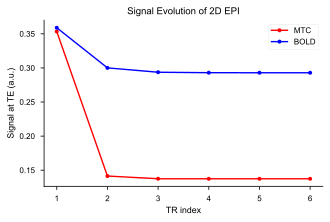

In [ ]:

fig,ax = plt.subplots(1,1,figsize=(5,3))
#plt.figure(figsize=(8, 4))

# TR_slice
#ax.plot(range(1, N_slices*N_volumes + 1), mtc_history, 'o-', markersize=4, color='red',label='slice 10')
#ax.plot(range(1, N_slices*N_volumes + 1), bold_history, 'o-', markersize=4, color='blue',label='slice 20')
#ax.set_xlabel('MT module index')

# TR_volume
ax.plot(range(1, N_volumes + 1), mtc_sig_history, 'o-', markersize=4, color='red',label='MTC')
ax.plot(range(1, N_volumes + 1), bold_sig_history, 'o-', markersize=4, color='blue',label='BOLD')
ax.set_xlabel('TR index')

ax.set_ylabel('Normalized $M_{z}$')
ax.set_ylabel('Signal at TE (a.u.)')
ax.set_title(f'Signal Evolution of 2D EPI')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#for i in range(1, N_volumes):
#    boundary = i * N_slices + 0.5
#    if i == 1:
#        plt.axvline(boundary, color='k', linestyle='--', alpha=0.5, label='TR Boundary')
#    else:
#        plt.axvline(boundary, color='k', linestyle='--', alpha=0.5)

#plt.axvspan(0.5, 4 * N_slices + 0.5, color='gray', alpha=0.1)



plt.legend()

plt.show()

In [9]:
mtc_5_history, mtc_5_sig_history = sim_TR_2DEPI(omega1_amp,5)
mtc_15_history, mtc_15_sig_history = sim_TR_2DEPI(omega1_amp,15)
mtc_25_history, mtc_25_sig_history = sim_TR_2DEPI(omega1_amp,25)

bold_5_history, bold_5_sig_history = sim_TR_2DEPI(0,5)
bold_15_history, bold_15_sig_history = sim_TR_2DEPI(0,15)
bold_25_history, bold_25_sig_history = sim_TR_2DEPI(0,25)

0.22952250558087958
0.2928926993867996
MTR= 0.21635975884203307


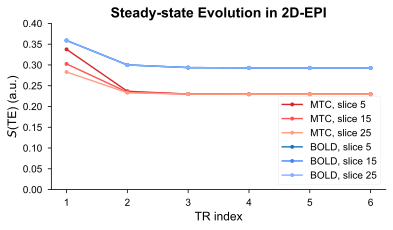

In [ ]:
print(mtc_5_sig_history[-1])
print(bold_5_sig_history[-1])
print('MTR=',1-mtc_5_sig_history[-1]/bold_5_sig_history[-1])


blue_palette = ['#1f77b4', '#4285f4', '#81b1ff']  
red_palette = ['#d62728', '#ff5252', '#ff9e80']

fig,ax = plt.subplots(1,1,figsize=(6,3))
#time_axis = np.arange(N_volumes)*TR_volume
ax.plot(range(1,N_volumes+1), mtc_5_sig_history, 'o-', markersize=4, color=red_palette[0],label='MTC, slice 5')
ax.plot(range(1,N_volumes+1), mtc_15_sig_history, 'o-', markersize=4, color=red_palette[1],label='MTC, slice 15')
ax.plot(range(1,N_volumes+1), mtc_25_sig_history, 'o-', markersize=4, color=red_palette[2],label='MTC, slice 25')
ax.plot(range(1,N_volumes+1), bold_5_sig_history, 'o-', markersize=4, color=blue_palette[0],label='BOLD, slice 5')
ax.plot(range(1,N_volumes+1), bold_15_sig_history, 'o-', markersize=4, color=blue_palette[1],label='BOLD, slice 15')
ax.plot(range(1,N_volumes+1), bold_25_sig_history, 'o-', markersize=4, color=blue_palette[2],label='BOLD, slice 25')

ax.set_title('Steady-state Evolution in 2D-EPI', fontsize=14, fontweight='bold')
ax.set_xlabel('TR index', fontsize=12)
ax.set_ylim([0,0.4])
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_ylabel('Normalized $M_{z}$', fontsize=12)
ax.set_ylabel('$S$(TE) (a.u.)', fontsize=12)
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)



ax.legend(loc='lower right', fontsize=10)

plt.show()
fig.savefig('steady_state_TR_2DEPI.png',format='png', bbox_inches='tight',dpi=600)

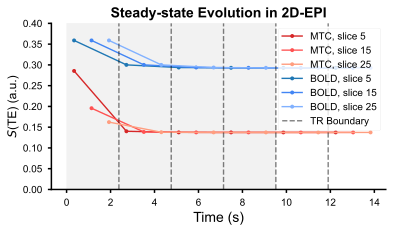

In [ ]:

blue_palette = ['#1f77b4', '#4285f4', '#81b1ff']  
red_palette = ['#d62728', '#ff5252', '#ff9e80']

fig,ax = plt.subplots(1,1,figsize=(6,3))
time_axis = np.arange(N_volumes)*TR_volume
ax.plot(time_axis+4*TR_slice+TE, mtc_5_sig_history, 'o-', markersize=4, color=red_palette[0],label='MTC, slice 5')
ax.plot(time_axis+14*TR_slice+TE, mtc_15_sig_history, 'o-', markersize=4, color=red_palette[1],label='MTC, slice 15')
ax.plot(time_axis+24*TR_slice+TE, mtc_25_sig_history, 'o-', markersize=4, color=red_palette[2],label='MTC, slice 25')
ax.plot(time_axis+4*TR_slice+TE, bold_5_sig_history, 'o-', markersize=4, color=blue_palette[0],label='BOLD, slice 5')
ax.plot(time_axis+14*TR_slice+TE, bold_15_sig_history, 'o-', markersize=4, color=blue_palette[1],label='BOLD, slice 15')
ax.plot(time_axis+24*TR_slice+TE, bold_25_sig_history, 'o-', markersize=4, color=blue_palette[2],label='BOLD, slice 25')

ax.set_title('Steady-state Evolution in 2D-EPI', fontsize=14, fontweight='bold')
ax.set_xlabel('Time (s)', fontsize=14)
ax.set_ylim([0,0.4])
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_ylabel('Normalized $M_{z}$', fontsize=12)
ax.set_ylabel('$S$(TE) (a.u.)', fontsize=12)
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for i in range(1, N_volumes):
    boundary = i * N_slices *TR_slice
    if i == 1:
        plt.axvline(boundary, color='k', linestyle='--', alpha=0.5, label='TR Boundary')
    else:
        plt.axvline(boundary, color='k', linestyle='--', alpha=0.5)

plt.axvspan(0, 4 * N_slices*TR_slice, color='gray', alpha=0.1)

ax.legend(loc='upper right', fontsize=10)

plt.show()
fig.savefig('steady_state_time_2DEPI.png',format='png', bbox_inches='tight',dpi=600)

# MT effect vs T1 effect

In [ ]:

GAMMA_Hz = 42.58 * 1e6 # Hz/T
GAMMA_rad = GAMMA_Hz * 2 * np.pi # rad/s/T

F_m = 0.1        #0.10
F_f = 1.0 - F_m

K_ex = 1.45         # Hz 
#k_fm = K_ex / F_f
#k_mf = K_ex / F_m  

R1_f = 0.4          # Hz
R1_m = 2.0          # Hz
R2_f = 1 / (50e-3)  # Hz (T2_f = 50ms)
T2_m = 11e-6        # s  (T2_m = 10us), 用于计算 Super-Lorentzian
T2s = 28e-3      # 28 ms

B1_scale = 1
FA_nominal = 9  # deg
#FA_nominal = 0   # BOLD
FA_deg = FA_nominal * B1_scale        # deg
N_pulse = 30        
#tau = 200e-6        # s, gap
dur = 100e-6        # s, pulse duration
interval = 300e-6   # s, interval between pulses
t_spoiler = 1500e-6 # s, spoiler duration

#tau = interval - dur        # s, gap

#omega1_amp = (FA_deg * np.pi / 180.0) / dur 

# EPI
TE = 24e-3       # 24 ms
FA_EPI = 70 * np.pi / 180
TR_volume = 2380e-3 # s
N_slices = 30
N_volumes = 4
target_slice = 10 # 第10层
TR_slice = TR_volume/N_slices

# On-resonance
df_hz = 0 
#g_B = super_lorentzian(2 * np.pi * df_hz, T2_m)
g_B = T2_m / np.sqrt(2 * np.pi)  # Gaussian line shape at 0 Hz
delta_w = 2 * np.pi * df_hz

In [ ]:
def super_lorentzian(delta_omega, T2):
    def integrand(u):
        denominator = np.abs(3 * u**2 - 1)
        if denominator < 1e-6: denominator = 1e-6
        return np.sqrt(2/np.pi)*(T2/denominator)*np.exp(-2*((delta_omega*T2)/denominator)**2)
    if delta_omega == 0:
        return T2 / np.sqrt(2 * np.pi)
    val, _ = quad(integrand, 0, 1, limit=100)
    return val

def get_system_matrix(omega1, delta_w, R_RFB,K_ex,F_m):
    F_f = 1 - F_m
    k_fm = K_ex / F_f
    k_mf = K_ex / F_m  
    A = np.array([
        [-R2_f, -delta_w,      0,               0],
        [delta_w, -R2_f,      -omega1,          0],
        [0,       omega1,     -(R1_f + k_fm),   k_mf],
        [0,       0,           k_fm,           -(R1_m + k_mf + R_RFB)]
    ])
    C = np.array([0, 0, R1_f * F_f, R1_m * F_m])
    return A, C

def evolve_step(M, A, C, dt):
    n = A.shape[0]
    A_ext = np.zeros((n+1, n+1))
    A_ext[:n, :n] = A
    A_ext[:n, n] = C
    M_ext = np.append(M, 1)
    M_new_ext = expm(A_ext * dt) @ M_ext
    return M_new_ext[:n]


def apply_mt_module(M, g_B, delta_w, dur,FA_deg,K_ex,F_m):
    tau = interval - dur
    omega1_amp = (FA_deg * np.pi / 180.0) / dur
    F_f = 1 - F_m

    # 0.5 (-)
    R_RFB05 = np.pi * (omega1_amp**2) * g_B / 4
    A, C = get_system_matrix(-omega1_amp/2, delta_w, R_RFB05,K_ex,F_m)
    M = evolve_step(M, A, C, dur)
    # Gap
    A, C = get_system_matrix(0, delta_w, 0,K_ex,F_m)
    M = evolve_step(M, A, C, tau)
    # 30 Pairs
    R_RFB = np.pi * (omega1_amp**2) * g_B
    A_pos, C_pos = get_system_matrix(omega1_amp, delta_w, R_RFB,K_ex,F_m)
    A_neg, C_neg = get_system_matrix(-omega1_amp, delta_w, R_RFB,K_ex,F_m)
    A_gap, C_gap = get_system_matrix(0, delta_w, 0,K_ex,F_m)
    
    for _ in range(N_pulse):
        M = evolve_step(M, A_pos, C_pos, dur)
        M = evolve_step(M, A_gap, C_gap, tau)
        M = evolve_step(M, A_neg, C_neg, dur)
        M = evolve_step(M, A_gap, C_gap, tau)
        
    # 0.5 (+)
    A, C = get_system_matrix(omega1_amp/2, delta_w, R_RFB05,K_ex,F_m)
    M = evolve_step(M, A, C, dur)
    # Spoiler Gap
    A, C = get_system_matrix(0, delta_w, 0,K_ex,F_m)
    M = evolve_step(M, A, C, tau + t_spoiler)
    return M


def sim_TR_2DEPI(FA_deg,dur,target_slice,K_ex,F_m):
    tau = interval - dur
    omega1_amp = (FA_deg * np.pi / 180.0) / dur
    F_f = 1 - F_m

    M_slice10 = np.array([0.0, 0.0, F_f, F_m])

    t_mt = (1 + N_pulse)*2*(dur+tau) + t_spoiler 
    t_recovery = TR_slice - t_mt  

    #mzf_history = []
    #signal_history = []

    for v in range(N_volumes):
        for s in range(1, N_slices + 1):
            M_slice10 = apply_mt_module(M_slice10, g_B, delta_w,dur,FA_deg,K_ex,F_m)
            # mzf_history.append(M_slice10[2]/F_f)    # TR_slice specific
            if s == target_slice:
                #mzf_history.append(M_slice10[2]/F_f)   # TR_volume specific
                mzf_before = M_slice10[2]
                #print(mzf_before/F_f)
                M_slice10[2] = mzf_before * np.cos(FA_EPI)
                M_slice10[0] = 0
                #M_slice10[1] = mzf_before * np.sin(FA_EPI)
                M_slice10[1] = 0
                sig = mzf_before * np.sin(FA_EPI) * np.exp(-TE/T2s)
                #signal_history.append(sig)  # TR_volume specific
                #print(sig/F_f)
                A, C = get_system_matrix(0, delta_w, 0,K_ex,F_m)
                M_slice10 = evolve_step(M_slice10, A, C, t_recovery)
            else:
                A, C = get_system_matrix(0, delta_w, 0,K_ex,F_m)
                M_slice10 = evolve_step(M_slice10, A, C, t_recovery)
                # signal_history.append(0)  # TR_slice specific
            
    return sig



## MTR: MT vs T1

In [112]:
def cal_MTR(dur,K_ex,F_m):
    mtc_sig = sim_TR_2DEPI(9,dur,1,K_ex,F_m)
    bold_sig = sim_TR_2DEPI(0,dur,1,K_ex,F_m)
    MTR=1-mtc_sig/bold_sig
    #print(f'dur = {dur}, MTR = {MTR}')
    return MTR

In [ ]:
T2_m = 10e-6  # s

# MT 2 min for ten points
dur_list = np.linspace(50, 150, 10)*1e-6
MTR_GM_list = []
MTR_WM_list = []
T1_GM_list = []
T1_WM_list = []

for dur_i in dur_list:
    MTR_GM = cal_MTR(dur_i, 1.45, 0.12) # GM, MT
    MTR_GM_list.append(MTR_GM)
    MTR_WM = cal_MTR(dur_i, 1.45, 0.24) # WM, MT
    MTR_WM_list.append(MTR_WM)

    T1_GM = cal_MTR(dur_i, 0, 0.12) # GM, MT
    T1_GM_list.append(T1_GM)
    T1_WM = cal_MTR(dur_i, 0, 0.24) # WM, MT
    T1_WM_list.append(T1_WM)

In [132]:
#dur_list_exp = [120, 110, 100, 90, 80]
#MTR_GM_exp = [0.1891, 0.2138, 0.2906, 0.2723, 0.3103]
#MTR_GM_exp = [0.2092, 0.2352, 0.3093, 0.2953, 0.3293]

#MTR_WM_exp = [0.2581, 0.2914, 0.3879, 0.3609, 0.3982]
#MTR_WM_exp = [0.2733, 0.3013, 0.4114, 0.3734, 0.4154]

dur_list_exp = [120, 110, 100, 90, 80]
MTR_GM_exp = [0.1891, 0.2138, 0.2356, 0.2723, 0.3103]
#MTR_GM_exp = [0.2092, 0.2352, 0.2953, 0.3293]

MTR_WM_exp = [0.2581, 0.2914, 0.3147, 0.3609, 0.3982]
#MTR_WM_exp = [0.2733, 0.3013, 0.3734, 0.4154]

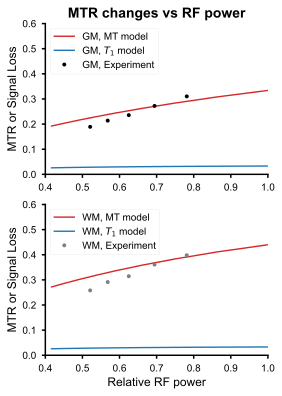

In [ ]:
blue_palette = ['#1f77b4', '#4285f4', '#81b1ff']  
red_palette = ['#d62728', '#ff5252', '#ff9e80']

fig,axes = plt.subplots(2,1,figsize=(4,6))

p_axis = 1/dur_list*1e-6/0.016
p_list_exp = np.array([1/120, 1/110, 1/100, 1/90, 1/80])/0.016

axes[0].plot(p_axis, MTR_GM_list, '-', markersize=4, color=red_palette[0],label='GM, MT model ')
axes[0].plot(p_axis, T1_GM_list, '-', markersize=4, color=blue_palette[0],label='GM, $T_1$ model')
axes[0].plot(p_list_exp, MTR_GM_exp, 'o', markersize=4, color='black',label='GM, Experiment')
axes[0].set_xlim([0.4,1])
axes[0].set_ylim([0,0.6])
axes[0].tick_params(axis='both', which='major', labelsize=10)
axes[0].set_ylabel('MTR or Signal Loss', fontsize=12)
axes[0].grid(False)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].legend(loc='upper left', fontsize=10)
axes[0].set_title('MTR changes vs RF power', fontsize=14, fontweight='bold')

axes[1].plot(p_axis, MTR_WM_list, '-', markersize=4, color=red_palette[0],label='WM, MT model')
axes[1].plot(p_axis, T1_WM_list, '-', markersize=4, color=blue_palette[0],label='WM, $T_1$ model')
axes[1].plot(p_list_exp, MTR_WM_exp, 'o', markersize=4, color='gray',label='WM, Experiment')
axes[1].set_xlabel('Relative RF power', fontsize=12)
axes[1].set_xlim([0.4,1])
axes[1].set_ylim([0,0.6])
axes[1].tick_params(axis='both', which='major', labelsize=10)
axes[1].set_ylabel('MTR or Signal Loss', fontsize=12)
axes[1].grid(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].legend(loc='upper left', fontsize=10)

plt.show()
fig.savefig('theory_MT_T1.png',format='png', bbox_inches='tight',dpi=600)